In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from dataclasses import dataclass
from datetime import datetime

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets
from torchvision.transforms import v2
from tqdm.auto import tqdm

In [3]:
writer = SummaryWriter(f'runs/mnist/vae_{datetime.now().strftime("%Y%m%d-%H%M%S")}')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
batch_size = 128
learning_rate = 1e-3
weight_decay = 1e-2
num_epochs = 100
latent_dim = 2
hidden_dim = 512


In [4]:
transform = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Lambda(lambda x: x.view(-1) - 0.5),
])

In [5]:
# Download and load the training data
train_data = datasets.MNIST(
    '~/.pytorch/MNIST_data/',
    download=True,
    train=True,
    transform=transform,
)
len(train_data)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 36928417.60it/s]


Extracting /root/.pytorch/MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 1178718.23it/s]


Extracting /root/.pytorch/MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 9873398.93it/s]


Extracting /root/.pytorch/MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 4158596.11it/s]

Extracting /root/.pytorch/MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /root/.pytorch/MNIST_data/MNIST/raw



60000

In [6]:
# Download and load the test data
test_data = datasets.MNIST(
    '~/.pytorch/MNIST_data/',
    download=True,
    train=False,
    transform=transform,
)
len(test_data)

10000

In [7]:
# Create data loaders
train_loader = torch.utils.data.DataLoader(
    train_data,
    batch_size=batch_size,
    shuffle=True,
)
test_loader = torch.utils.data.DataLoader(
    test_data,
    batch_size=batch_size,
    shuffle=False,
)

In [8]:
@dataclass
class VAEOutput:
    """
    Dataclass for VAE output.

    Attributes:
        z_dist (torch.distributions.Distribution): The distribution of the latent variable z.
        z_sample (torch.Tensor): The sampled value of the latent variable z.
        x_recon (torch.Tensor): The reconstructed output from the VAE.
        loss (torch.Tensor): The overall loss of the VAE.
        loss_recon (torch.Tensor): The reconstruction loss component of the VAE loss.
        loss_kl (torch.Tensor): The KL divergence component of the VAE loss.
    """
    z_dist: torch.distributions.Distribution
    z_sample: torch.Tensor
    x_recon: torch.Tensor

    loss: torch.Tensor
    loss_recon: torch.Tensor
    loss_kl: torch.Tensor

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class VAEOutput:
    """
    Dataclass to hold VAE output.
    """
    def __init__(self, z_dist, z_sample, x_recon, loss, loss_recon, loss_kl):
        self.z_dist = z_dist
        self.z_sample = z_sample
        self.x_recon = x_recon
        self.loss = loss
        self.loss_recon = loss_recon
        self.loss_kl = loss_kl

class VAE(nn.Module):
    """
    Variational Autoencoder (VAE) class.

    Args:
        input_dim (int): Dimensionality of the input data.
        hidden_dim (int): Dimensionality of the hidden layer.
        latent_dim (int): Dimensionality of the latent space.
        depth (int): Number of layers to add in encoder and decoder.
    """

    def __init__(self, input_dim, hidden_dim, latent_dim, depth):
        super(VAE, self).__init__()

        encoder_layers = [
            nn.Linear(input_dim, hidden_dim),
            nn.SiLU(),  # Swish activation function
        ]
        for _ in range(depth):
            encoder_layers.extend([
                nn.Linear(hidden_dim // (2 ** _), hidden_dim // (2 ** (_ + 1))),
                nn.SiLU(),  # Swish activation function
            ])
        encoder_layers.extend([
            nn.Linear(hidden_dim // (2 ** depth), 2 * latent_dim),  # 2 for mean and variance
        ])

        decoder_layers = [
            nn.Linear(latent_dim, hidden_dim // (2 ** depth)),
            nn.SiLU(),  # Swish activation function
        ]
        for _ in range(depth):
            decoder_layers.extend([
                nn.Linear(hidden_dim // (2 ** (depth - _)), hidden_dim // (2 ** (depth - _ - 1))),
                nn.SiLU(),  # Swish activation function
            ])
        decoder_layers.extend([
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid(),
        ])

        self.encoder = nn.Sequential(*encoder_layers)
        self.decoder = nn.Sequential(*decoder_layers)

        self.softplus = nn.Softplus()

    def encode(self, x, eps: float = 1e-8):
        """
        Encodes the input data into the latent space.

        Args:
            x (torch.Tensor): Input data.
            eps (float): Small value to avoid numerical instability.

        Returns:
            torch.distributions.MultivariateNormal: Normal distribution of the encoded data.
        """
        x = self.encoder(x)
        mu, logvar = torch.chunk(x, 2, dim=-1)
        scale = self.softplus(logvar) + eps
        scale_tril = torch.diag_embed(scale)

        return torch.distributions.MultivariateNormal(mu, scale_tril=scale_tril)

    def reparameterize(self, dist):
        """
        Reparameterizes the encoded data to sample from the latent space.

        Args:
            dist (torch.distributions.MultivariateNormal): Normal distribution of the encoded data.

        Returns:
            torch.Tensor: Sampled data from the latent space.
        """
        return dist.rsample()

    def decode(self, z):
        """
        Decodes the data from the latent space to the original input space.

        Args:
            z (torch.Tensor): Data in the latent space.

        Returns:
            torch.Tensor: Reconstructed data in the original input space.
        """
        return self.decoder(z)

    def forward(self, x, compute_loss: bool = True):
        """
        Performs a forward pass of the VAE.

        Args:
            x (torch.Tensor): Input data.
            compute_loss (bool): Whether to compute the loss or not.

        Returns:
            VAEOutput: VAE output dataclass.
        """
        dist = self.encode(x)
        z = self.reparameterize(dist)
        recon_x = self.decode(z)

        if not compute_loss:
            return VAEOutput(
                z_dist=dist,
                z_sample=z,
                x_recon=recon_x,
                loss=None,
                loss_recon=None,
                loss_kl=None,
            )

        # compute loss terms
        loss_recon = F.binary_cross_entropy(recon_x, x + 0.5, reduction='none').sum(-1).mean()
        std_normal = torch.distributions.MultivariateNormal(
            torch.zeros_like(z, device=z.device),
            scale_tril=torch.eye(z.shape[-1], device=z.device).unsqueeze(0).expand(z.shape[0], -1, -1),
        )
        loss_kl = torch.distributions.kl.kl_divergence(dist, std_normal).mean()

        loss = loss_recon + loss_kl

        return VAEOutput(
            z_dist=dist,
            z_sample=z,
            x_recon=recon_x,
            loss=loss,
            loss_recon=loss_recon,
            loss_kl=loss_kl,
        )
'''
# Example usage:
input_dim = 784  # Example input dimension for MNIST images
hidden_dim = 512
latent_dim = 32
depth = 5  # Add three layers in both encoder and decoder

vae = VAE(input_dim, hidden_dim, latent_dim, depth)
print(vae)
'''

'\n# Example usage:\ninput_dim = 784  # Example input dimension for MNIST images\nhidden_dim = 512\nlatent_dim = 32\ndepth = 5  # Add three layers in both encoder and decoder\n\nvae = VAE(input_dim, hidden_dim, latent_dim, depth)\nprint(vae)\n'

incresing the depth once

In [11]:
model = VAE(input_dim=784, hidden_dim=hidden_dim, latent_dim=latent_dim,depth=3).to(device)
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
#print(f'Number of parameters: {num_params:,}')

model

VAE(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): SiLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): SiLU()
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): SiLU()
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): SiLU()
    (8): Linear(in_features=64, out_features=4, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): SiLU()
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): SiLU()
    (4): Linear(in_features=128, out_features=256, bias=True)
    (5): SiLU()
    (6): Linear(in_features=256, out_features=512, bias=True)
    (7): SiLU()
    (8): Linear(in_features=512, out_features=784, bias=True)
    (9): Sigmoid()
  )
  (softplus): Softplus(beta=1, threshold=20)
)

In [12]:
# create an optimizer object
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

In [ ]:
def train(model, dataloader, optimizer, prev_updates, writer=None):
    """
    Trains the model on the given data.

    Args:
        model (nn.Module): The model to train.
        dataloader (torch.utils.data.DataLoader): The data loader.
        loss_fn: The loss function.
        optimizer: The optimizer.
    """
    model.train()  # Set the model to training mode

    for batch_idx, (data, target) in enumerate(tqdm(dataloader)):
        n_upd = prev_updates + batch_idx

        data = data.to(device)

        optimizer.zero_grad()  # Zero the gradients

        output = model(data)  # Forward pass
        loss = output.loss

        loss.backward()

        if n_upd % 100 == 0:
            # Calculate and log gradient norms
            total_norm = 0.0
            for p in model.parameters():
                if p.grad is not None:
                    param_norm = p.grad.data.norm(2)
                    total_norm += param_norm.item() ** 2
            total_norm = total_norm ** (1. / 2)

            #print(f'Step {n_upd:,} (N samples: {n_upd*batch_size:,}), Loss: {loss.item():.4f} (Recon: {output.loss_recon.item():.4f}, KL: {output.loss_kl.item():.4f}) Grad: {total_norm:.4f}')

            if writer is not None:
                global_step = n_upd
                writer.add_scalar('Loss/Train', loss.item(), global_step)
                writer.add_scalar('Loss/Train/BCE', output.loss_recon.item(), global_step)
                writer.add_scalar('Loss/Train/KLD', output.loss_kl.item(), global_step)
                writer.add_scalar('GradNorm/Train', total_norm, global_step)
        # gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()  # Update the model parameters

    return prev_updates + len(dataloader)

In [ ]:
bce_losses = []
kld_losses = []

def test(model, dataloader, cur_step, writer=None):
    """
    Tests the model on the given data.

    Args:
        model (nn.Module): The model to test.
        dataloader (torch.utils.data.DataLoader): The data loader.
        cur_step (int): The current step.
        writer: The TensorBoard writer.
    """
    model.eval()  # Set the model to evaluation mode
    test_loss = 0
    test_recon_loss = 0
    test_kl_loss = 0

    with torch.no_grad():
        for data, target in tqdm(dataloader, desc='Testing'):
            data = data.to(device)
            data = data.view(data.size(0), -1)  # Flatten the data

            output = model(data, compute_loss=True)  # Forward pass

            test_loss += output.loss.item()
            test_recon_loss += output.loss_recon.item()
            test_kl_loss += output.loss_kl.item()

    test_loss /= len(dataloader)
    test_recon_loss /= len(dataloader)
    test_kl_loss /= len(dataloader)
    print(f'====> Test set loss: {test_loss:.4f} (BCE: {test_recon_loss:.4f}, KLD: {test_kl_loss:.4f})')
    # Append losses to the lists
    bce_losses.append(test_recon_loss)
    kld_losses.append(test_kl_loss)

    if writer is not None:

        writer.add_scalar('Loss/Test', test_loss, global_step=cur_step)
        writer.add_scalar('Loss/Test/BCE', output.loss_recon.item(), global_step=cur_step)
        writer.add_scalar('Loss/Test/KLD', output.loss_kl.item(), global_step=cur_step)

        # Log reconstructions
        writer.add_images('Test/Reconstructions', output.x_recon.view(-1, 1, 28, 28), global_step=cur_step)
        writer.add_images('Test/Originals', data.view(-1, 1, 28, 28), global_step=cur_step)

        # Log random samples from the latent space
        z = torch.randn(16, latent_dim).to(device)
        samples = model.decode(z)
        writer.add_images('Test/Samples', samples.view(-1, 1, 28, 28), global_step=cur_step)

In [ ]:
prev_updates = 0
for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    prev_updates = train(model, train_loader, optimizer, prev_updates, writer=writer)
    test(model, test_loader, prev_updates, writer=writer)

Epoch 1/100


  0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 188.1867 (BCE: 186.0214, KLD: 2.1653)
Epoch 2/100


  0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 183.5293 (BCE: 181.2610, KLD: 2.2683)
Epoch 3/100


  0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 178.7059 (BCE: 176.0498, KLD: 2.6561)
Epoch 4/100


  0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 177.3217 (BCE: 174.5634, KLD: 2.7584)
Epoch 5/100


  0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 172.1109 (BCE: 168.8396, KLD: 3.2713)
Epoch 6/100


  0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 171.3215 (BCE: 168.0721, KLD: 3.2494)
Epoch 7/100


  0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 171.6077 (BCE: 168.0274, KLD: 3.5803)
Epoch 8/100


  0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 171.1810 (BCE: 167.6912, KLD: 3.4898)
Epoch 9/100


  0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 167.7361 (BCE: 164.3344, KLD: 3.4017)
Epoch 10/100


  0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 169.8466 (BCE: 166.1566, KLD: 3.6900)
Epoch 11/100


  0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 167.5084 (BCE: 163.9272, KLD: 3.5812)
Epoch 12/100


  0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 174.4931 (BCE: 170.6824, KLD: 3.8108)
Epoch 13/100


  0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 167.0150 (BCE: 163.3292, KLD: 3.6858)
Epoch 14/100


  0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 176.0543 (BCE: 172.4257, KLD: 3.6286)
Epoch 15/100


  0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 178.9042 (BCE: 175.4958, KLD: 3.4084)
Epoch 16/100


  0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 171.9041 (BCE: 168.1614, KLD: 3.7427)
Epoch 17/100


  0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 170.4464 (BCE: 166.9551, KLD: 3.4913)
Epoch 18/100


  0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 167.8286 (BCE: 164.2607, KLD: 3.5678)
Epoch 19/100


  0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 170.1306 (BCE: 166.3819, KLD: 3.7486)
Epoch 20/100


  0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 170.1228 (BCE: 166.2630, KLD: 3.8598)
Epoch 21/100


  0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 172.5822 (BCE: 168.8557, KLD: 3.7266)
Epoch 22/100


  0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 167.1774 (BCE: 163.6073, KLD: 3.5701)
Epoch 23/100


  0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 163.9337 (BCE: 160.0828, KLD: 3.8509)
Epoch 24/100


  0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 174.3327 (BCE: 170.7981, KLD: 3.5345)
Epoch 25/100


  0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 168.8204 (BCE: 165.0606, KLD: 3.7598)
Epoch 26/100


  0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 164.8825 (BCE: 161.0692, KLD: 3.8132)
Epoch 27/100


  0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 163.3219 (BCE: 159.3705, KLD: 3.9514)
Epoch 28/100


  0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 173.9733 (BCE: 170.4024, KLD: 3.5709)
Epoch 29/100


  0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 168.5212 (BCE: 164.9798, KLD: 3.5414)
Epoch 30/100


  0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 166.8606 (BCE: 163.1906, KLD: 3.6700)
Epoch 31/100


  0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 167.4442 (BCE: 163.5006, KLD: 3.9436)
Epoch 32/100


  0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 165.7609 (BCE: 161.8000, KLD: 3.9609)
Epoch 33/100


  0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 167.8778 (BCE: 164.1718, KLD: 3.7060)
Epoch 34/100


  0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 172.1710 (BCE: 168.6321, KLD: 3.5389)
Epoch 35/100


  0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 169.8440 (BCE: 166.1239, KLD: 3.7201)
Epoch 36/100


  0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 169.8430 (BCE: 166.2013, KLD: 3.6417)
Epoch 37/100


  0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 168.8625 (BCE: 165.0085, KLD: 3.8540)
Epoch 38/100


  0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 167.4079 (BCE: 163.5747, KLD: 3.8332)
Epoch 39/100


  0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 166.2913 (BCE: 162.4618, KLD: 3.8295)
Epoch 40/100


  0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 167.7028 (BCE: 163.8819, KLD: 3.8209)
Epoch 41/100


  0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 164.9121 (BCE: 161.0054, KLD: 3.9067)
Epoch 42/100


  0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 182.4358 (BCE: 178.5479, KLD: 3.8879)
Epoch 43/100


  0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 172.5122 (BCE: 168.9529, KLD: 3.5593)
Epoch 44/100


  0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 174.3572 (BCE: 170.8447, KLD: 3.5124)
Epoch 45/100


  0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 171.1269 (BCE: 167.4324, KLD: 3.6944)
Epoch 46/100


  0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 169.0028 (BCE: 165.3082, KLD: 3.6946)
Epoch 47/100


  0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 170.0748 (BCE: 166.4012, KLD: 3.6736)
Epoch 48/100


  0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 168.0448 (BCE: 164.2073, KLD: 3.8375)
Epoch 49/100


  0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 167.4246 (BCE: 163.5911, KLD: 3.8335)
Epoch 50/100


  0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 165.6508 (BCE: 161.7318, KLD: 3.9190)
Epoch 51/100


  0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 168.5234 (BCE: 164.6605, KLD: 3.8629)
Epoch 52/100


  0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 167.1374 (BCE: 163.0606, KLD: 4.0768)
Epoch 53/100


  0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 167.2593 (BCE: 163.2256, KLD: 4.0337)
Epoch 54/100


  0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 184.3799 (BCE: 180.1295, KLD: 4.2504)
Epoch 55/100


  0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 177.3908 (BCE: 172.9444, KLD: 4.4463)
Epoch 56/100


  0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 173.3331 (BCE: 168.4968, KLD: 4.8364)
Epoch 57/100


  0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 173.0465 (BCE: 168.5435, KLD: 4.5030)
Epoch 58/100


  0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 172.9750 (BCE: 168.5605, KLD: 4.4145)
Epoch 59/100


  0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 171.6874 (BCE: 167.0885, KLD: 4.5989)
Epoch 60/100


  0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 166.0442 (BCE: 161.3714, KLD: 4.6728)
Epoch 61/100


  0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 166.2436 (BCE: 161.5704, KLD: 4.6732)
Epoch 62/100


  0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 165.4090 (BCE: 160.7311, KLD: 4.6780)
Epoch 63/100


  0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 175.8517 (BCE: 170.7766, KLD: 5.0751)
Epoch 64/100


  0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 172.7203 (BCE: 167.9883, KLD: 4.7320)
Epoch 65/100


  0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 175.3390 (BCE: 170.7621, KLD: 4.5768)
Epoch 66/100


  0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 169.0897 (BCE: 164.5841, KLD: 4.5056)
Epoch 67/100


  0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 182.3005 (BCE: 178.1514, KLD: 4.1490)
Epoch 68/100


  0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 177.5873 (BCE: 173.2690, KLD: 4.3183)
Epoch 69/100


  0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 172.7596 (BCE: 168.4449, KLD: 4.3147)
Epoch 70/100


  0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 173.4165 (BCE: 169.0596, KLD: 4.3568)
Epoch 71/100


  0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 169.7861 (BCE: 165.3570, KLD: 4.4291)
Epoch 72/100


  0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 172.3214 (BCE: 168.0458, KLD: 4.2756)
Epoch 73/100


  0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 169.1596 (BCE: 164.8128, KLD: 4.3468)
Epoch 74/100


  0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 170.7610 (BCE: 166.3349, KLD: 4.4261)
Epoch 75/100


  0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 171.1392 (BCE: 166.6962, KLD: 4.4431)
Epoch 76/100


  0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 168.5483 (BCE: 164.2065, KLD: 4.3418)
Epoch 77/100


  0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 173.9995 (BCE: 169.2766, KLD: 4.7229)
Epoch 78/100


  0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 170.7700 (BCE: 166.0084, KLD: 4.7615)
Epoch 79/100


  0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 179.5299 (BCE: 175.1320, KLD: 4.3978)
Epoch 80/100


  0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 180.3223 (BCE: 176.0069, KLD: 4.3155)
Epoch 81/100


  0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 178.5803 (BCE: 174.1107, KLD: 4.4696)
Epoch 82/100


  0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 181.8020 (BCE: 176.9893, KLD: 4.8126)
Epoch 83/100


  0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 175.0009 (BCE: 170.8117, KLD: 4.1892)
Epoch 84/100


  0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 170.9289 (BCE: 166.6461, KLD: 4.2828)
Epoch 85/100


  0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 169.8420 (BCE: 165.6251, KLD: 4.2170)
Epoch 86/100


  0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 174.6389 (BCE: 170.4235, KLD: 4.2154)
Epoch 87/100


  0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 167.9295 (BCE: 163.4971, KLD: 4.4324)
Epoch 88/100


  0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 169.1294 (BCE: 164.8989, KLD: 4.2305)
Epoch 89/100


  0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 166.8572 (BCE: 162.4341, KLD: 4.4231)
Epoch 90/100


  0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 170.3261 (BCE: 165.9892, KLD: 4.3369)
Epoch 91/100


  0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 195.1023 (BCE: 191.1004, KLD: 4.0019)
Epoch 92/100


  0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 171.4438 (BCE: 167.3240, KLD: 4.1199)
Epoch 93/100


  0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 171.0105 (BCE: 166.8438, KLD: 4.1666)
Epoch 94/100


  0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 176.1365 (BCE: 171.9702, KLD: 4.1663)
Epoch 95/100


  0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 174.9327 (BCE: 170.7348, KLD: 4.1980)
Epoch 96/100


  0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 173.6569 (BCE: 169.6329, KLD: 4.0240)
Epoch 97/100


  0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 175.3392 (BCE: 171.3544, KLD: 3.9848)
Epoch 98/100


  0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 169.6560 (BCE: 165.7547, KLD: 3.9013)
Epoch 99/100


  0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 169.4246 (BCE: 165.3607, KLD: 4.0639)
Epoch 100/100


  0%|          | 0/469 [00:00<?, ?it/s]

Testing:   0%|          | 0/79 [00:00<?, ?it/s]

====> Test set loss: 168.0014 (BCE: 163.9791, KLD: 4.0224)


depth 6 epoch 100

In [ ]:
print("BCE_losses")
print(bce_losses)
print("KDL losses")
print(kld_losses)

BCE_losses
[186.0213650087767, 181.2610348085814, 176.04980449435078, 174.56336781948428, 168.83959169025664, 168.07209932351415, 168.0273748470258, 167.6911883776701, 164.33439771434928, 166.15656869622725, 163.92723566369165, 170.68235604974288, 163.32921397535108, 172.42572639561908, 175.49580499190319, 168.16137791887115, 166.95514186424546, 164.26073446153086, 166.3819236272498, 166.2629925691629, 168.85566730740703, 163.60726233373714, 160.0828305015081, 170.7981273795985, 165.06058762948723, 161.0692488271979, 159.3704665944546, 170.4023835387411, 164.97980760019036, 163.19062573396707, 163.50058466271508, 161.79995283295835, 164.17183984684038, 168.6320806575727, 166.1238650551325, 166.2013182821153, 165.00845163079757, 163.57468153555183, 162.46180396743966, 163.8818797823749, 161.00544642194916, 178.5479276632961, 168.95289689076097, 170.84471999542623, 167.43244161485117, 165.30819335164904, 166.40118292313588, 164.20727191393888, 163.59112065955054, 161.73181789736205, 164.

depth 3 epoch 100

In [ ]:
print("BCE_losses")
print(bce_losses)
print("KDL losses")
print(kld_losses)

BCE_losses
[164.54211445096172, 151.71646291998368, 144.60490050496935, 142.25407033026974, 138.60184189035922, 139.37467280520667, 139.12734454191184, 136.15297863151454, 138.84831701351118, 135.0360592226439, 138.48864456369907, 136.73646342603467, 137.46007402637338, 135.1526405237898, 133.49529961694645, 133.0129537461679, 134.68004376375222, 135.13741331462617, 133.75406859192668, 136.46452534349658, 133.68674816662752, 132.80004380624504, 135.22779073594492, 133.56445418732076, 134.64944824991346, 138.11128341095358, 131.04234932042377, 133.22203199169303, 132.2809519707402, 132.24731145931196, 130.7356354918661, 131.5131931546368, 132.51319006424916, 132.23643860635877, 133.05553687373293, 131.59737743908846, 131.216091494017, 132.57584921921355, 131.28081811832476, 130.90201819697512, 131.7256088256836, 129.99005059350895, 130.37323828588558, 131.2594026975994, 130.67222817336457, 131.33189353459997, 131.74760127972954, 131.0254715545268, 130.49517484254474, 133.4765441508233, 

depth 4, epoch 100

In [ ]:
print("BCE_losses")
print(bce_losses)
print("KDL losses")
print(kld_losses)

BCE_losses
[182.4171824394902, 161.65865683253807, 156.75273769716674, 153.54550344732743, 147.766551729999, 143.37243304675138, 143.0461014373393, 142.50531469417524, 145.99679275705844, 145.01881003078026, 140.98534702349312, 139.8774893072587, 140.11308810077136, 138.61170727693582, 139.14379670348347, 137.52518067178846, 137.5922297224214, 137.25483162795442, 135.79372299773783, 141.08177803136127, 138.9526987196524, 137.67626953125, 136.11271841314775, 135.91511352152764, 134.7895691304267, 135.4300727361365, 133.9635460769074, 136.2463534391379, 137.69474956657314, 135.59987543806244, 133.90685928924174, 134.78141707408278, 138.71514554566974, 134.61999898017208, 144.65732796584504, 135.38696163515502, 134.67969377734994, 135.2386752744264, 134.09950352922272, 134.36568779281424, 136.81479586830622, 136.99872733973248, 142.12733903715883, 133.6551157311548, 137.5085132454015, 138.9168748493436, 138.75599960134, 139.31029964398735, 139.01857583734053, 140.60101337674297, 135.03269

DEPTH 5 , EPOCH 100

In [ ]:
print("BCE_losses")
print(bce_losses)
print("KDL losses")
print(kld_losses)

BCE_losses
[172.0509942935992, 177.9433504901355, 177.8287979319126, 172.84993599034564, 176.24770036528383, 170.7890145989913, 168.37372424934483, 167.94871520996094, 164.49640182301968, 164.02221505853194, 172.79662390600276, 168.1332980771608, 167.52845493751235, 168.0417163704015, 168.29689837105667, 176.35177148746538, 170.12245564521115, 167.56214074243474, 166.07678782789014, 163.1470306010186, 165.33730615543413, 165.2868213895001, 162.0044538280632, 161.05697071703173, 160.32230019871193, 158.84532030322885, 158.81139383436758, 159.14837105666535, 157.05432689039014, 158.39110671417623, 160.272985530805, 170.47045067895817, 166.61111199101316, 159.15547489214546, 161.0180490228194, 161.99085670181466, 159.02268325226217, 160.93010122564775, 158.57317516471767, 158.6398386894902, 164.09774278085442, 163.9806817935992, 169.50199156169649, 164.82958598076542, 164.1640652040892, 163.5136691709108, 161.88421746748912, 165.0335882645619, 165.67715550676178, 162.5669094037406, 164.02



```
depth = 6
```



depth = 5



```
increasing depth 4
```



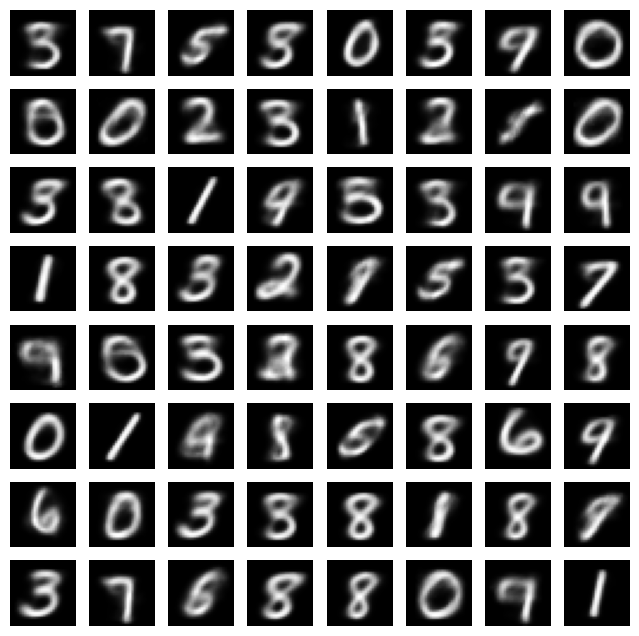

In [ ]:
z = torch.randn(64, latent_dim).to(device)
samples = model.decode(z)
# samples = torch.sigmoid(samples)

# print first sample
# print(samples[0])

# Plot the generated images
fig, ax = plt.subplots(8, 8, figsize=(8, 8))
for i in range(8):
    for j in range(8):
        ax[i, j].imshow(samples[i*8+j].view(28, 28).cpu().detach().numpy(), cmap='gray')
        ax[i, j].axis('off')

# plt.show()
plt.savefig('vae_mnist.webp')

In [ ]:
# encode and plot the z values for the train set
model.eval()
z_all = []
y_all = []
with torch.no_grad():
    for data, target in tqdm(train_loader, desc='Encoding'):
        data = data.to(device)
        output = model(data, compute_loss=False)
        z_all.append(output.z_sample.cpu().numpy())
        y_all.append(target.numpy())

Encoding:   0%|          | 0/469 [00:00<?, ?it/s]

In [ ]:
import numpy as np
z_all = np.concatenate(z_all, axis=0)
y_all = np.concatenate(y_all, axis=0)

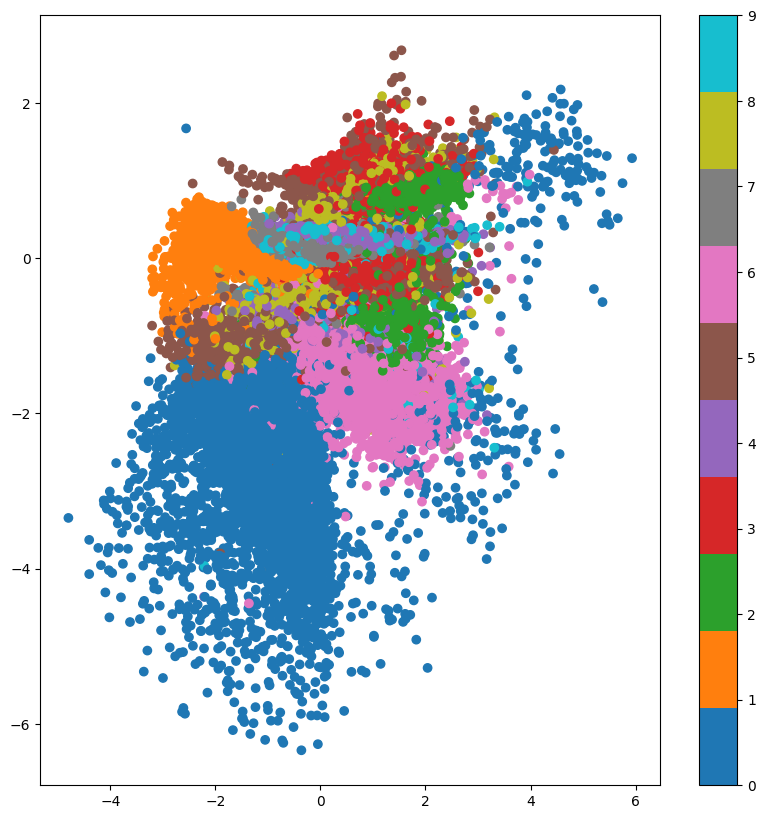

In [ ]:
plt.figure(figsize=(10, 10))
plt.scatter(z_all[:, 0], z_all[:, 1], c=y_all, cmap='tab10')
plt.colorbar()
# plt.show()
plt.savefig('vae_mnist_2d_scatter.webp')

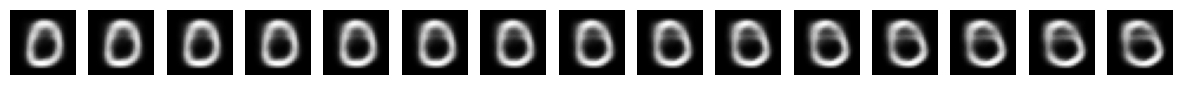

In [ ]:
n = 15
z1 = torch.linspace(-0, 1, n)
z2 = torch.zeros_like(z1) + 2
z = torch.stack([z1, z2], dim=-1).to(device)
samples = model.decode(z)
samples = torch.sigmoid(samples)

# Plot the generated images
fig, ax = plt.subplots(1, n, figsize=(n, 1))
for i in range(n):
    ax[i].imshow(samples[i].view(28, 28).cpu().detach().numpy(), cmap='gray')
    ax[i].axis('off')

plt.savefig('vae_mnist_interp.webp')